In [ ]:
 import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------- 1. Channel and waveform definitions --------
def qpsk_mod(N):
    """Generate N QPSK symbols with unit power."""
    bits = np.random.randint(0, 2, size=(N, 2))
    return ((2*bits[:,0]-1) + 1j*(2*bits[:,1]-1)) / np.sqrt(2)

In [ ]:
print((qpsk_mod(16).shape))

(16,)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------- 1. Channel and waveform definitions --------
def qpsk_mod(N):
    """Generate N QPSK symbols with unit power."""
    bits = np.random.randint(0, 2, size=(N, 2))
    return ((2*bits[:,0]-1) + 1j*(2*bits[:,1]-1)) / np.sqrt(2)

def jakes_taps(N, L, Ts, f_max, pwr):
    """
    Generate time-varying multipath taps using the sum-of-sinusoids (Jakes) model.
    N: number of samples, L: number of delay taps, Ts: symbol period, f_max: max Doppler,
    pwr: array of average power per tap.
    Returns h[n,l] with shape (N, L).
    """
    M = 16  # number of sinusoids per path
    h = np.zeros((N, L), dtype=np.complex128)
    n = np.arange(N)[:, None]
    for l in range(L):
        a = np.sqrt(pwr[l] / M)
        phi = 2*np.pi*np.random.rand(M)
        theta = 2*np.pi*np.random.rand(M)
        # time variation due to Doppler for each sinusoid
        exps = np.exp(1j * (phi + 2*np.pi*f_max*np.cos(theta) * n * Ts))
        h[:, l] = a * np.sum(exps, axis=1)
    return h

def toeplitz_channel(h):
    """
    Convert per-tap sequences h[n,l] to a convolution matrix H of shape (N, N-L+1).
    Each column corresponds to a shifted version of the tap sequence.
    """
    N, L = h.shape
    M = N - L + 1
    H = np.zeros((N, M), dtype=np.complex128)
    for col in range(M):
        for row in range(N):
            delay = row - col
            if 0 <= delay < L:
                H[row, col] = h[row, delay]
    return H

def generate_block(Ns=48, Nb=12, L=3, P=4):
    """
    Generate a transmit block with Ns data symbols, Nb pilot symbols, and L zeros (guard).
    Pilots and data are divided into P sub-blocks (time-spread pilots).
    Returns (u, pilot_indices), where u is the transmit vector of length N=Ns+Nb+L.
    """
    s_per_block = Ns // P
    b_per_block = Nb // P
    data = np.concatenate([qpsk_mod(s_per_block) for _ in range(P)])
    pilots = np.concatenate([np.ones(b_per_block) for _ in range(P)])  # BPSK pilots
    u_parts, pilot_idx = [], []
    offset = 0
    for p in range(P):
        u_parts.append(data[p*s_per_block:(p+1)*s_per_block])
        offset += s_per_block
        u_parts.append(pilots[p*b_per_block:(p+1)*b_per_block])
        pilot_idx += list(range(offset, offset+b_per_block))
        offset += b_per_block
    u = np.concatenate(u_parts + [np.zeros(L)])
    return u, np.array(pilot_idx, dtype=int)

def add_awgn(x, snr_db):
    """Add AWGN to vector x at the given SNR (per symbol)."""
    snr = 10**(snr_db/10)
    p_signal = np.mean(np.abs(x)**2)
    n0 = p_signal / snr
    noise = np.sqrt(n0/2) * (np.random.randn(*x.shape) + 1j*np.random.randn(*x.shape))
    return x + noise

def ls_estimate(pilot_idx, u, r, L):
    """
    Compute a simple LS estimate of the channel taps from pilot positions.
    h_hat[t,l] is estimated by dividing received pilot sample by transmitted pilot
    and assuming the channel is constant over the block.  Then reconstruct H_hat taps.
    (A proper BEM-LS estimator can replace this.)
    Returns a tap sequence of shape (N, L).
    """
    N = len(u)
    h_ls = np.zeros((N, L), dtype=np.complex128)
    # crude LS per delay: treat first tap only; simple interpolation
    # For demonstration, assume single-tap constant channel per pilot
    for l in range(L):
        # pilot samples must be shifted by delay
        valid = pilot_idx[pilot_idx - l >= 0]
        if len(valid) > 0:
            y_samples = r[valid]  # received pilot
            x_samples = u[valid - l]  # transmitted symbol (shift)
            # LS estimate at this tap (constant over block)
            h_l = np.mean(y_samples / x_samples)
            h_ls[:, l] = h_l
    return h_ls

# -------- 2. Dataset generation --------
def make_dataset(num_samples=500, snr_db=10, params=None):
    """
    Generate a dataset of training examples.  Each example consists of:
    - Input vector X: concatenated (real, imag) of pilot transmit vector u_b,
      received vector r, LS estimate h_ls (flattened), and previous channel estimate.
    - Target y: flattened true channel taps (real, imag).
    """
    if params is None:
        params = {
            'block': {'Ns':48, 'Nb':12, 'L':3, 'P':4},
            'chan': {'L':3, 'Ts':1e-6, 'f_max':100, 'pwr':[0.8,0.1,0.1]},
        }
    Ns = params['block']['Ns']; Nb = params['block']['Nb']; L = params['block']['L']
    N = Ns + Nb + L
    dataset = []
    prev_H_hat = np.zeros((N, L), dtype=np.complex128)
    for _ in range(num_samples):
        # 1. transmit block
        u, pilot_idx = generate_block(**params['block'])
        # 2. channel
        h = jakes_taps(N, params['chan']['L'], params['chan']['Ts'],
                       params['chan']['f_max'], params['chan']['pwr'])
        H = toeplitz_channel(h)
        # 3. received signal
        r_clean = H @ u[:(N-L+1)]
        r_full = np.concatenate([r_clean, np.zeros(L-1)])  # pad to length N
        r_noisy = add_awgn(r_full, snr_db)
        # 4. LS estimate (toy version)
        h_ls = ls_estimate(pilot_idx, u, r_noisy, L)
        # 5. Build input features
        u_b = np.zeros(N, dtype=np.complex128)
        u_b[pilot_idx] = u[pilot_idx]
        def split_re_im(z):
            return np.concatenate([z.real, z.imag])
        X = np.concatenate([
            split_re_im(u_b),
            split_re_im(r_noisy),
            split_re_im(h_ls.flatten()),
            split_re_im(prev_H_hat.flatten())
        ]).astype(np.float32)
        y = split_re_im(h.flatten()).astype(np.float32)
        dataset.append((X, y))
        prev_H_hat = h_ls.copy()
    return dataset, N, L

# -------- 3. Neural network definition --------
class ChannelNet(nn.Module):
    """
    Simple fully-connected network for channel estimation.
    Input dimension: 2*(N + N + N*L + N*L)
    Output dimension: 2*N*L (real+imag taps)
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# -------- 4. Training and evaluation --------
def train_model(dataset, N, L, epochs=10, batch_size=32):
    """Train the neural network on the dataset and return the trained model."""
    input_dim = len(dataset[0][0])
    output_dim = len(dataset[0][1])
    model = ChannelNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()  # L1 loss (MAE) as suggested in the paper
    # Create DataLoader
    data = [(torch.from_numpy(X), torch.from_numpy(y)) for (X, y) in dataset]
    # simple batching
    for epoch in range(epochs):
        np.random.shuffle(data)
        total_loss = 0.0
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            X_batch = torch.stack([item[0] for item in batch])
            y_batch = torch.stack([item[1] for item in batch])
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, average MAE: {total_loss / (len(data)/batch_size):.4f}")
    return model

def evaluate(model, test_dataset):
    """Compute MSE on a test dataset."""
    model.eval()
    with torch.no_grad():
        total_se = 0.0
        total_count = 0
        for X, y in test_dataset:
            X_t = torch.from_numpy(X)[None, :]
            y_t = torch.from_numpy(y)[None, :]
            y_hat = model(X_t).numpy()
            total_se += np.sum((y_hat - y_t.numpy())**2)
            total_count += len(y)
        mse = total_se / total_count
        print(f"Test NMSE: {mse:.6f}")
    return mse


Epoch 1/5, average MAE: 0.2284
Epoch 2/5, average MAE: 0.1552
Epoch 3/5, average MAE: 0.1323
Epoch 4/5, average MAE: 0.1114
Epoch 5/5, average MAE: 0.1001
Test NMSE: 0.020642

Evaluating model performance across SNR levels...
Testing SNR = 0 dB
Test NMSE: 0.048134
Testing SNR = 2 dB
Test NMSE: 0.036502
Testing SNR = 4 dB
Test NMSE: 0.029726
Testing SNR = 6 dB
Test NMSE: 0.028543
Testing SNR = 8 dB
Test NMSE: 0.024024
Testing SNR = 10 dB
Test NMSE: 0.022231
Testing SNR = 12 dB
Test NMSE: 0.022104
Testing SNR = 14 dB
Test NMSE: 0.021055
Testing SNR = 16 dB
Test NMSE: 0.019263
Testing SNR = 18 dB
Test NMSE: 0.018358
Testing SNR = 20 dB
Test NMSE: 0.019516


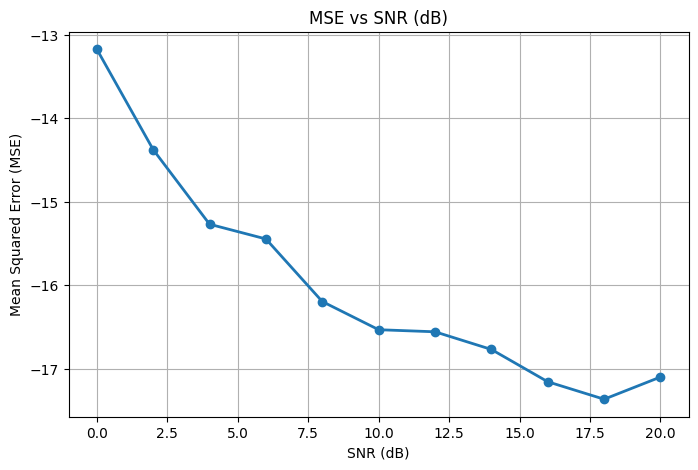

In [ ]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # -------- Existing training and evaluation --------
    train_data, N, L = make_dataset(num_samples=1000, snr_db=10)
    test_data, _, _ = make_dataset(num_samples=200, snr_db=10)
    model = train_model(train_data, N, L, epochs=5, batch_size=64)
    evaluate(model, test_data)

    # -------- MSE vs SNR(dB) Plot --------
    snr_range = np.arange(0, 21, 2)  # 0, 2, 4, ..., 20 dB
    mse_values = []

    print("\nEvaluating model performance across SNR levels...")
    for snr in snr_range:
        print(f"Testing SNR = {snr} dB")
        test_data, _, _ = make_dataset(num_samples=200, snr_db=snr)
        mse = evaluate(model, test_data)
        mse_values.append(mse)

    mse_values_db = 10 * np.log10(mse_values)
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(snr_range, mse_values_db, marker='o', linewidth=2)
    plt.grid(True)
    plt.title("MSE vs SNR (dB)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.gca()  # optional: often we want low SNR (noisy) on right
    plt.show()


The jakes_tap below models the channel as per the jakes model given in the paper and the equation number 3.